In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 加载数据
df1 = pd.read_csv("..\Data\data1.csv")

# 假设'X1'到'X24'是特征列，'Y(1=default, 0=non-default)'是标签列
X = df1.loc[:, 'X1':'X24']  # 选择特征列
y = df1['Y(1=default, 0=non-default)']  # 选择标签列

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 将pandas DataFrame转换为DMatrix格式，这是XGBoost的专用格式
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 设置XGBoost的参数
params = {
    'max_depth': 3,  # 树的深度
    'eta': 0.3,  # 学习率
    'objective': 'binary:logistic',  # 因为是二分类问题
    'eval_metric': 'logloss'  # 评估指标，这里使用对数损失
}

# 训练模型
num_round = 100  # 训练轮数
bst = xgb.train(params, dtrain, num_round)

# 使用训练好的模型进行预测
y_pred = bst.predict(dtest)
# 因为XGBoost输出的是概率值，我们需要将概率转换为二分类结果
y_pred_class = [1 if x > 0.5 else 0 for x in y_pred]

# 计算准确率
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.2%}")

# 如果你想要保存模型以便后续使用
bst.save_model('../Data/Q2_xgb_model.model')

# 如果你想要加载模型进行预测
# loaded_model = xgb.Booster()
# loaded_model.load_model('xgb_model.model')
# predictions_on_new_data = loaded_model.predict(new_data_dmatrix)

Accuracy: 81.00%


d:\ProgramData\anaconda3\envs\pyTorchgpuEnv\Lib\site-packages\xgboost\core.py:160: UserWarning: [17:49:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


Accuracy: 0.77
AUC: 0.7961904761904762

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       140
           1       0.64      0.53      0.58        60

    accuracy                           0.77       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.76      0.77      0.76       200



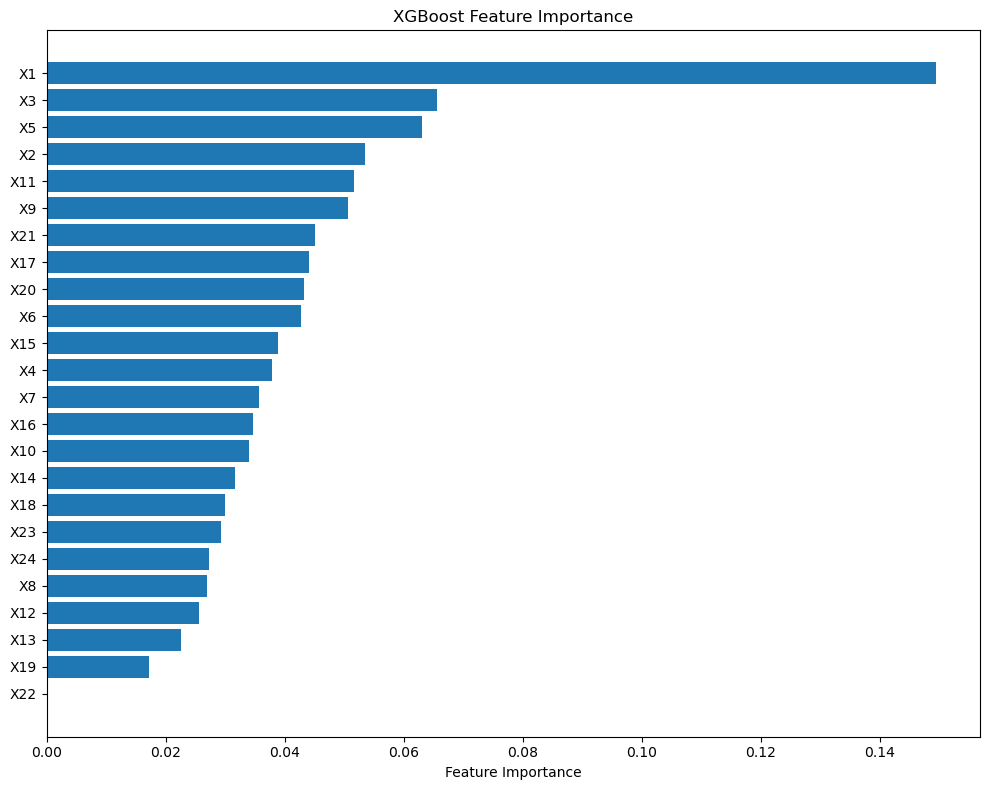


Credit Score Statistics:
count    1000.000000
mean        0.302134
std         0.256043
min         0.007641
25%         0.078137
50%         0.222009
75%         0.484777
max         0.975647
Name: Credit_Score, dtype: float64

Results saved to 'german_credit_data_with_scores.csv'


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 1. 加载数据
df = pd.read_csv('..\Data\data1.csv')  # 请确保文件路径正确

# 2. 数据预处理
X = df.drop('Y(1=default, 0=non-default)', axis=1)  # 假设'Target'是目标变量
y = df['Y(1=default, 0=non-default)']

# 处理类别变量（如果有的话）
X = pd.get_dummies(X, drop_first=True)

# 3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 5. 定义XGBoost模型
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# 6. 定义超参数网格
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 7. 使用网格搜索进行超参数调优
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

# 8. 获取最佳模型
best_model = grid_search.best_estimator_

# 9. 在测试集上进行预测
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# 10. 评估模型性能
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"AUC: {auc}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 11. 特征重要性可视化
feature_importance = best_model.feature_importances_
feature_names = X.columns

# 对特征重要性进行排序
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

# 可视化
plt.figure(figsize=(10, 8))
plt.barh(range(len(sorted_importance)), sorted_importance)
plt.yticks(range(len(sorted_importance)), sorted_features)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.savefig('../Data/Q2_XGBoost_feature_importance.png')
plt.tight_layout()
plt.show()

# 12. 计算个体信用得分
credit_scores = best_model.predict_proba(X_scaled)[:, 1]

# 将信用得分添加到原始数据框中
df['Credit_Score'] = credit_scores

# 打印信用得分的描述性统计
print("\nCredit Score Statistics:")
print(df['Credit_Score'].describe())

# 13. 保存结果
df.to_csv('../Data/Q2_german_credit_data_with_scores.csv', index=False)
print("\nResults saved to 'german_credit_data_with_scores.csv'")